# Exploratory data analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/01-gyl-exploratory-data-analysis.ipynb)

In [21]:
from io import BytesIO
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import tempfile
import zipfile

from PIL import Image
import requests
import torch

In [22]:
# Global Configuration

seed = 123

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


## Load Dataset

In [5]:
url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'

temp = tempfile.gettempdir()
cache = Path(temp) / 'rgb.zip'

if cache.exists():
  print('Loading RGB data from cache')
else:
  print('Loading RGB data from remote')
  res = requests.get(url, allow_redirects=True)
  cache.write_bytes(res.content)
zip_data = BytesIO(cache.read_bytes())

Loading RGB data from cache


EuroSAT_RGB/Forest/Forest_864.jpg


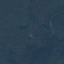

In [4]:
with zipfile.ZipFile(zip_data, 'r') as zip:
  images = [f for f in zip.namelist() if f.endswith('.jpg')]
  image = Image.open(BytesIO(zip.read(images[0])))

print(images[0])
image

In [26]:
class EuroSATDataset(torch.utils.data.Dataset):
  @staticmethod
  def download(download_dir: Path = Path('/workspace/code/data')):
    url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
    save_path = download_dir / 'rgb.zip'
    extract_path = download_dir / 'rgb/'

    os.makedirs(download_dir, exist_ok=True)

    if save_path.exists():
      # Zip file already downloaded and saved on local machine
      print(f"File {save_path} exists already - not overwriting")
    else:
      # Zip file is not downloaded yet
      print(f"Starting download from {url}")
      response = requests.get(url, allow_redirects=True)
      with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                _ = file.write(chunk)
      print(f"File downloaded and saved to {save_path}")

    if extract_path.exists():
      # Zip file already extracted to local storage
      print(f"File {extract_path} exists already - not overwriting")
    else:
      # Zip file not extracted yet
      print(f"Starting extracting {extract_path}")
      with zipfile.ZipFile(save_path, "r") as zip_ref:
          zip_ref.extractall(extract_path)
      print(f"File extracted to {extract_path}")

  def __init__(self, root_dir):
    self.root_dir = root_dir

    self.observations = list()
    self.classes = os.listdir(root_dir)
    for label in self.classes:
        class_dir = os.path.join(root_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.lower().endswith('.jpg'):
                self.observations.append({"image_path": img_path, "label": label})

  def __len__(self):
    return len(self.observations)

  def __getitem__(self, idx):
    image_path = self.observations[idx]["image_path"]
    image = Image.open(image_path)
    label = self.observations[idx]["label"]
    label_num = self.classes.index(label)
    return {"image": image, "label": label_num}

  @classmethod
  def from_subset(cls, original, indices: list[int]):
      # Create a new instance with the same properties as the original
      subset = cls(root_dir=original.root_dir)

      # Filter the observations based on the subset indices
      subset.observations = [original.observations[i] for i in indices]
      subset.classes = original.classes  # Keep class list consistent

      print(f'Created a subset with {len(subset.observations):_} of {len(original.observations):_} images')

      return subset

In [15]:
EuroSATDataset.download()

File /workspace/code/data/rgb.zip exists already - not overwriting
File /workspace/code/data/rgb exists already - not overwriting


['River', 'AnnualCrop', 'SeaLake', 'Highway', 'Residential', 'HerbaceousVegetation', 'PermanentCrop', 'Industrial', 'Forest', 'Pasture']


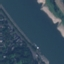

In [20]:
dataset = EuroSATDataset(Path('/workspace/code/data/rgb/EuroSAT_RGB/'))
print(dataset.classes)
dataset[0]['image']

In [28]:
ids = [i for i in range(0, len(dataset.observations))]
labels = [x["label"] for x in dataset.observations]

train_ids, test_ids = train_test_split(ids, train_size=0.8, random_state=seed, stratify=labels)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=seed, stratify=[labels[i] for i in test_ids])

dataset_train = EuroSATDataset.from_subset(dataset, train_ids)
dataset_val = EuroSATDataset.from_subset(dataset, val_ids)
dataset_test = EuroSATDataset.from_subset(dataset, test_ids)

Created a subset with 21_600 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 2_700 of 27_000 images
